In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re
import numpy.ma as ma

from hbmep.config import Config
from hbmep.model.utils import Site as site

from models import NonHierarchicalBayesianModel
from constants import (
    DATA_PATH,
    TOML_PATH
)

config = Config(toml_path=TOML_PATH)
model = NonHierarchicalBayesianModel(config=config)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
df_CIRC = pd.read_csv("/home/andres/data/hbmep-processed/L_CIRC/data.csv")
df_RCML = pd.read_csv("/home/andres/data/hbmep-processed/J_RCML_000/data.csv")
df_SHAP = pd.read_csv("/home/andres/data/hbmep-processed/J_SHAP/data.csv")
df_SMA_LAR = pd.read_csv("/home/andres/data/hbmep-processed/C_SMA_LAR/data.csv")


In [5]:
combination_CIRC = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/L_CIRC/combine.pkl", "rb"))
combination_RCML = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/J_RCML_000/combine.pkl", "rb"))
combination_SHAP = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/J_SHAP/combine.pkl", "rb"))
combination_SMA_LAR = pickle.load(open("/home/andres/repos/rat-mapping-paper/reports/C_SMA_LAR/combine.pkl", "rb"))

## Circ

In [11]:
subjects_CIRC = df_CIRC['participant'].unique()
combos_CIRC = ['Vertex', 'Radius', 'Diameter']
electrodes_CIRC = ['C6LC', 'C6LE', 'C6LN', 'C6LNE', 'C6LNW', 'C6LS', 'C6LSE', 'C6LSW', 'C6LW']
muscles_CIRC = model.response

temp = ['C6LE-C6LW','C6LNE-C6LSW','C6LS-C6LN','C6LSE-C6LNW']
ord = []
arr_CIRC = []
mask_CIRC = []
for sub in subjects_CIRC:
    for combo in combos_CIRC:
        for elec in electrodes_CIRC:
            for m in muscles_CIRC:
                if combo == 'Vertex':
                    position = '-'+elec
                if combo == 'Radius':
                    position = elec + '-' + 'C6LC'
                if combo == 'Diameter':
                    for e in electrodes_CIRC:
                        if elec != e:
                            temppos = elec + '-' + e
                            if temppos in temp:
                                position = temppos
                key = (sub, position, m)
                
                if key in combination_CIRC.keys():
                    tcomb = combination_CIRC[key]['a']
                    tcomb = tcomb.reshape(-1, 1)
                    arr_CIRC.append(tcomb)
                    mask_CIRC.append(np.full((4000,1), False))
                else:
                    arr_CIRC.append(np.zeros(4000).reshape(-1, 1))
                    mask_CIRC.append(np.full((4000, 1), True))
                    
arr_CIRC = np.array(arr_CIRC)
arr_CIRC = arr_CIRC.reshape(len(subjects_CIRC), len(combos_CIRC),len(electrodes_CIRC), len(muscles_CIRC), *arr_CIRC.shape[1:])
mask_CIRC = np.array(mask_CIRC)
mask_CIRC = mask_CIRC.reshape(len(subjects_CIRC), len(combos_CIRC),len(electrodes_CIRC),len(muscles_CIRC), *mask_CIRC.shape[1:])

arr_CIRC = ma.masked_array(arr_CIRC, mask=mask_CIRC)
arr_CIRC = arr_CIRC[..., 0]
                
arr_CIRC.shape #subjects, combos, electrodes, muscles

(8, 3, 9, 6, 4000)

## Big v Small

In [9]:
subjects_BvS = df_SMA_LAR["participant"].unique().tolist()
sizes_BvS = ['S', 'B']
positions_BvS = df_SMA_LAR.compound_position.unique().tolist()
# positions = sorted([p for p in positions if (p.split('-')[0] == "" or p.split('-')[1] == "")])
targets_BvS = ['LL','L', 'LM1', 'LM2','LM', 'M']
levels_BvS = ['C5', 'C6']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles_BvS = set([m[3] for m in combination_SMA_LAR.keys()])

arr_BvS = []
mask_BvS = []

for subject in subjects_BvS:
    for level in levels_BvS:
        for target in targets_BvS:
            for size in sizes_BvS:
                for muscle in muscles_BvS:
                    position = f"-{level}{target}"
                    key = (subject, position, size, muscle)
                    if key in combination_SMA_LAR.keys():
                        currenta = combination_SMA_LAR[key]['a']
                        currenta = currenta.reshape(-1, 1)
                        arr_BvS.append(currenta)
                        mask_BvS.append(np.full((4000, 1), False))
                    else:
                        arr_BvS.append(np.zeros(4000).reshape(-1, 1))
                        mask_BvS.append(np.full((4000, 1), True))

arr_BvS = np.array(arr_BvS)
arr_BvS = arr_BvS.reshape(len(subjects_BvS), len(levels_BvS), len(targets_BvS), len(sizes_BvS), len(muscles_BvS), *arr_BvS.shape[1:])
mask_BvS = np.array(mask_BvS)
mask_BvS = mask_BvS.reshape(len(subjects_BvS), len(levels_BvS), len(targets_BvS), len(sizes_BvS), len(muscles_BvS), *mask_BvS.shape[1:])

arr_BvS = ma.masked_array(arr_BvS, mask=mask_BvS)
arr_BvS = arr_BvS[..., 0]

arr_BvS.shape #subects, levels, targets, sizes, muscles

(8, 2, 6, 2, 6, 4000)

## J_SHAP

In [16]:
subjects_SHAP = df_SHAP.participant.unique().tolist()
charges_SHAP = df_SHAP.compound_charge_params.unique().tolist()
charges_SHAP = [c for c in charges_SHAP if c != "80-0-20-400"]
positions_SHAP = df_SHAP.compound_position.unique().tolist()

# M-L, bipolar
positions_SHAP = [p for p in positions_SHAP if not ("" in p.split("-"))]
positions_SHAP = [p for p in positions_SHAP if p.split('-')[0][-1] != p.split('-')[1][-1]]

directions_SHAP = ['L-M', 'M-L']
segments_SHAP = ["C6", "C7", "C8"]

arr_SHAP = []
mask_SHAP = []

for subject in subjects_SHAP:
    for segment in segments_SHAP:
        for direction in directions_SHAP:
            for charge in charges_SHAP:
                for muscle in model.response:
                    l, r = direction.split("-")
                    position = segment + l + "-" + segment + r

                    c = (subject, position, charge, muscle)
                    if c in combination_SHAP:
                        current_a = combination_SHAP[c]['a']
                        current_a = current_a.reshape(-1, 1)
                        arr_SHAP.append(current_a)
                        
                        mask_SHAP.append(np.full((4000, 1), False))
                        
                    else:
                        arr_SHAP.append(np.zeros(4000).reshape(-1, 1))
                        mask_SHAP.append(np.full((4000, 1), True))
                        
arr_SHAP = np.array(arr_SHAP)
arr_SHAP = arr_SHAP.reshape(len(subjects_SHAP), len(segments_SHAP), len(directions_SHAP), len(charges_SHAP), len(model.response), *arr_SHAP.shape[1:])      

mask_SHAP = np.array(mask_SHAP)
mask_SHAP = mask_SHAP.reshape(len(subjects_SHAP), len(segments_SHAP), len(directions_SHAP), len(charges_SHAP), len(model.response), *mask_SHAP.shape[1:])

arr_SHAP = ma.masked_array(arr_SHAP, mask=mask_SHAP)
arr_SHAP = arr_SHAP[..., 0]

arr_SHAP.shape #subjects, segments, directions, charges, muscle

(8, 3, 2, 3, 6, 4000)

## RCML

In [19]:
subjects_RCML = df_RCML["participant"].unique().tolist()
positions_RCML = ['L', 'M']
levels_RCML = ['C5', 'C6', 'C7', 'C8']
# levels = ['C5-C6', 'C6-C7', 'C7-C8']
# positions = [p for p in positions if (p.split('-')[1][2] in targets and p.split('-')[1][1] != "7")]
muscles_RCML = model.response

a = []
mask_RCML = []
for subject in subjects_RCML:
    for position in positions_RCML:
        for level in levels_RCML:
            for muscle in muscles_RCML:
                # l, r = level.split('-')
                # pos = l + position + '-' + r + position
                pos = '-' + level + position
                key = (subject, pos, muscle)
                if key in combination_RCML.keys():
                    temp = combination_RCML[key]['a']
                    temp = temp.reshape(-1, 1)
                    a.append(temp)
                    mask_RCML.append(np.full((4000,1), False))  
                else: 
                    mask_RCML.append(np.full((4000,1), True))
                    a.append(np.zeros(4000).reshape(-1, 1))
arr_RCML = np.array(a)
arr_RCML = arr_RCML.reshape(len(subjects_RCML), len(positions_RCML),len(levels_RCML), len(muscles_RCML), *arr_RCML.shape[1:])
mask_RCML = np.array(mask_RCML)
mask_RCML = mask_RCML.reshape(len(subjects_RCML), len(positions_RCML),len(levels_RCML),len(muscles_RCML), *mask_RCML.shape[1:])

arr_RCML = ma.masked_array(arr_RCML, mask=mask_RCML)
arr_RCML = arr_RCML[..., 0]

arr_RCML.shape #subjects, positions, levels, muscle

(8, 2, 4, 6, 4000)

## Graphing

In [ ]:
# arr_RCML -- subjects, positions, levels, muscle
# arr_BvS -- subects, levels, targets, sizes, muscles
# arr_SHAP -- subjects, levels, directions, charges, muscle
# arr_CIRC -- subjects, combos, electrodes, muscles... combos is vertex/radius/diameter

In [ ]:
big_electrodes = arr_BvS[:, :, :, 1, ...].mean(axis=-1)
small_electrodes = arr_BvS[:, :, :, 0, ...].mean(axis=-1)


b_mean = big_electrodes.mean()
b_sem = stats.sem(big_electrodes.compressed())

s_mean = small_electrodes.mean()
s_sem = stats.sem(small_electrodes.compressed())

x_labels = ['Big', 'Small']
values = [b_mean, s_mean]
sem = [b_sem, s_sem]
# Convert x_labels to a numerical format for plotting
x_numeric = np.array([0.5, 1.5])
cols = ['black', 'red']

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x_numeric, y=values, s=100, hue = x_labels, palette=cols, edgecolor='black')

# Add error bars
plt.errorbar(x_numeric[0], values[0], yerr=sem[0], fmt='o', color='black', capsize=10, elinewidth=2)
plt.errorbar(x_numeric[1], values[1], yerr=sem[1], fmt='o', color='red', capsize=10, elinewidth=2)

# Customize the plot
plt.xticks(ticks=x_numeric, labels=x_labels)
plt.ylabel('Threshold')
plt.xlabel('Size Category')
# plt.title('Values with SEM for Big and Small')
plt.xlim(0, 2)

# Show plot
plt.show()

In [73]:
stats.ttest_ind(big_electrodes,small_electrodes,alternative="two-sided", axis=(0, 1, 2,3))

TtestResult(statistic=-5.206337853932841, pvalue=2.5345282397048726e-07, df=700.0)

<ErrorbarContainer object of 3 artists>

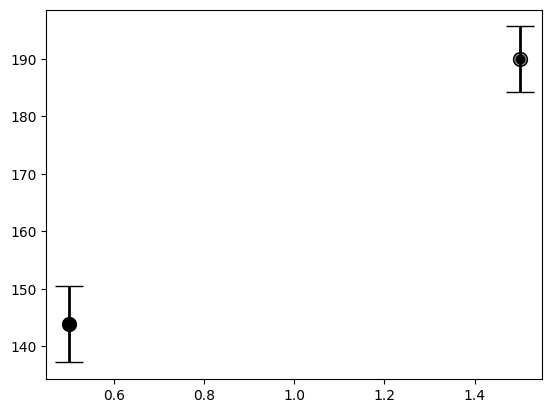

In [59]:
# To plot all together
# arr_RCML -- subjects, positions, levels, muscle
# arr_BvS -- subects, levels, targets, sizes, muscles
# arr_SHAP -- subjects, levels, directions, charges, muscle
# arr_CIRC -- subjects, combos, electrodes, muscles... combos is vertex/radius/diameter
lat_mean = []
med_mean = []

lat_RCML = arr_RCML[:,0,...].mean(axis=-1)
med_RCML = arr_RCML[:,1,...].mean(axis=-1)
lat_mean.append(lat_RCML.mean())
med_mean.append(med_RCML.mean())

lat_BvS = arr_BvS[:,0,...].mean(axis=-1)





categories = ['RCML', 'SHAP', 'CIRC']
means1 = [10, 5]  # First set of means
sem1 = [1, 0.5]   # SEMs for the first set of means

means2 = [8, 6]   # Second set of means
sem2 = [1.2, 0.7] # SEMs for the second set of means

# Convert categories to a numerical format for plotting
x_numeric = np.arange(len(categories))  # [0, 1]

# Create the scatter plot
plt.figure(figsize=(8, 6))

# Plot the first set of means
plt.scatter(x_numeric - 0.1, means1, color='black', s=100, edgecolor='black', label='Means 1')
plt.errorbar(x_numeric - 0.1, means1, yerr=sem1, fmt='o', color='black', capsize=5, elinewidth=2)

# Plot the second set of means
plt.scatter(x_numeric + 0.1, means2, color='grey', s=100, edgecolor='black', label='Means 2')
plt.errorbar(x_numeric + 0.1, means2, yerr=sem2, fmt='o', color='grey', capsize=5, elinewidth=2)

# Customize the plot
plt.xticks(ticks=x_numeric, labels=categories)
plt.xlim(-0.5, len(categories) - 0.5)  # Adjust the limits to make space for both sets of points
plt.ylabel('Value')
plt.xlabel('Category')
plt.title('Comparison of Two Sets of Means with SEM')

# Add a legend
plt.legend()

# Show plot
plt.show()


In [49]:
x_numeric

array([0.5, 1.5])

In [35]:
s_sem

5.715521111627386